In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import numpy as np
from collections import Counter
import pandas as pd
from feedback.plotting import *
from sklearn.metrics import cohen_kappa_score

In [3]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [5]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [6]:
style_size = 'paper'

In [7]:
eval_columns = ["update_contact","inadequate_food", "earlier_pickup","system_problem","direction_problem","recipient_problem","donor_problem","positive_comment"]
nice_names = ["Update Contact","Inadequate Food","Earlier Pickup","System Problem","Direction Problem","Recipient Problem","Donor Problem","Positive Comment"]

In [8]:
def get_accuracy(ground_truth,predicted):
    return 1-np.mean(np.abs(predicted-ground_truth))

def get_precision(ground_truth, predicted):
    return np.sum(predicted * ground_truth) / (np.sum(predicted) + 1e-8)

def get_recall(ground_truth, predicted):
    return np.sum(predicted * ground_truth) / (np.sum(ground_truth) + 1e-8)

def convert(x):
    if x is True or str(x).lower() == "true":
        return 1
    elif x is False or str(x).lower() == "false":
        return 0
    elif x in [0, 1]:
        return x
    elif str(x) in ["0", "1"]:
        return int(x)
    else:
        return 0

## Loading Data

In [9]:
naveen_annotations = pd.read_csv("../../data/annotations/pre_deploy_eval.csv")
naveen_annotations = naveen_annotations[naveen_annotations['annotator'] == 'naveen'].sort_values(by=['volunteer_comment'])
naveen_annotations_array = naveen_annotations[eval_columns]
naveen_annotations_array = np.array(naveen_annotations_array)

In [10]:
jingwu_annotations = pd.read_csv("../../data/annotations/pre_deploy_eval.csv")
jingwu_annotations = jingwu_annotations[jingwu_annotations['annotator'] == 'jingwu'].sort_values(by=['volunteer_comment'])
jingwu_annotations_array = jingwu_annotations[eval_columns]
jingwu_annotations_array = np.array(jingwu_annotations_array)

In [11]:
pre_deploy_array = (naveen_annotations_array+jingwu_annotations_array)/2

In [12]:
ground_truth_post_deploy = pd.read_csv("../../data/annotations/post_deploy_eval.csv").sort_values(by=['volunteer_comment'])
naveen_post_annotations = np.array(ground_truth_post_deploy[ground_truth_post_deploy['annotator'] == 'naveen'][eval_columns])
sean_post_annotations = np.array(ground_truth_post_deploy[ground_truth_post_deploy['annotator'] == 'sean'][eval_columns])
post_deploy_array = (naveen_post_annotations+sean_post_annotations)/2

In [13]:
naveen_annotations = pd.read_csv("../../data/annotations/post_deploy_eval.csv")
naveen_annotations = naveen_annotations[naveen_annotations['annotator'] == 'naveen'].sort_values(by=['volunteer_comment'])
naveen_annotations_array_post = naveen_annotations[eval_columns]
naveen_annotations_array_post = np.array(naveen_annotations_array_post)

In [14]:
sean_annotations = pd.read_csv("../../data/annotations/post_deploy_eval.csv")
sean_annotations = sean_annotations[sean_annotations['annotator'] == 'sean'].sort_values(by=['volunteer_comment'])
sean_annotations_array = sean_annotations[eval_columns]
sean_annotations_array = np.array(sean_annotations_array)

In [15]:
post_deploy_array = (naveen_annotations_array_post+sean_annotations_array)/2

## Evaluation

In [16]:
model_names = ["gpt-4o-mini","gpt-4o","meta-llama_Meta-Llama-3.1-8B-Instruct-Turbo","deepseek-ai_DeepSeek-R1-Distill-Qwen-14B"]
nice_names = ["GPT-4o Mini","GPT-4o","Llama 3.1","DeepSeek R1"]

data = [] 

for name in model_names:
    df_eval = pd.read_csv("../../results/evaluation/{}.csv".format(name))
    df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
    df_eval = df_eval.sort_values(by=['volunteer_comment'])
    df_eval = df_eval.reset_index(drop=True)
    df_eval = df_eval[eval_columns]    
    data.append(np.array(df_eval))
accuracies = [get_accuracy(pre_deploy_array,d) for d in data]
precisions = [get_precision(pre_deploy_array,d) for d in data]
recalls = [get_recall(pre_deploy_array,d) for d in data]
f1_scores = [2/(1/get_recall(pre_deploy_array,d)+1/get_precision(pre_deploy_array,d)) for d in data]

/tmp/ipykernel_3918617/2648333936.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_3918617/2648333936.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_3918617/2648333936.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_3918617/2648333936.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)


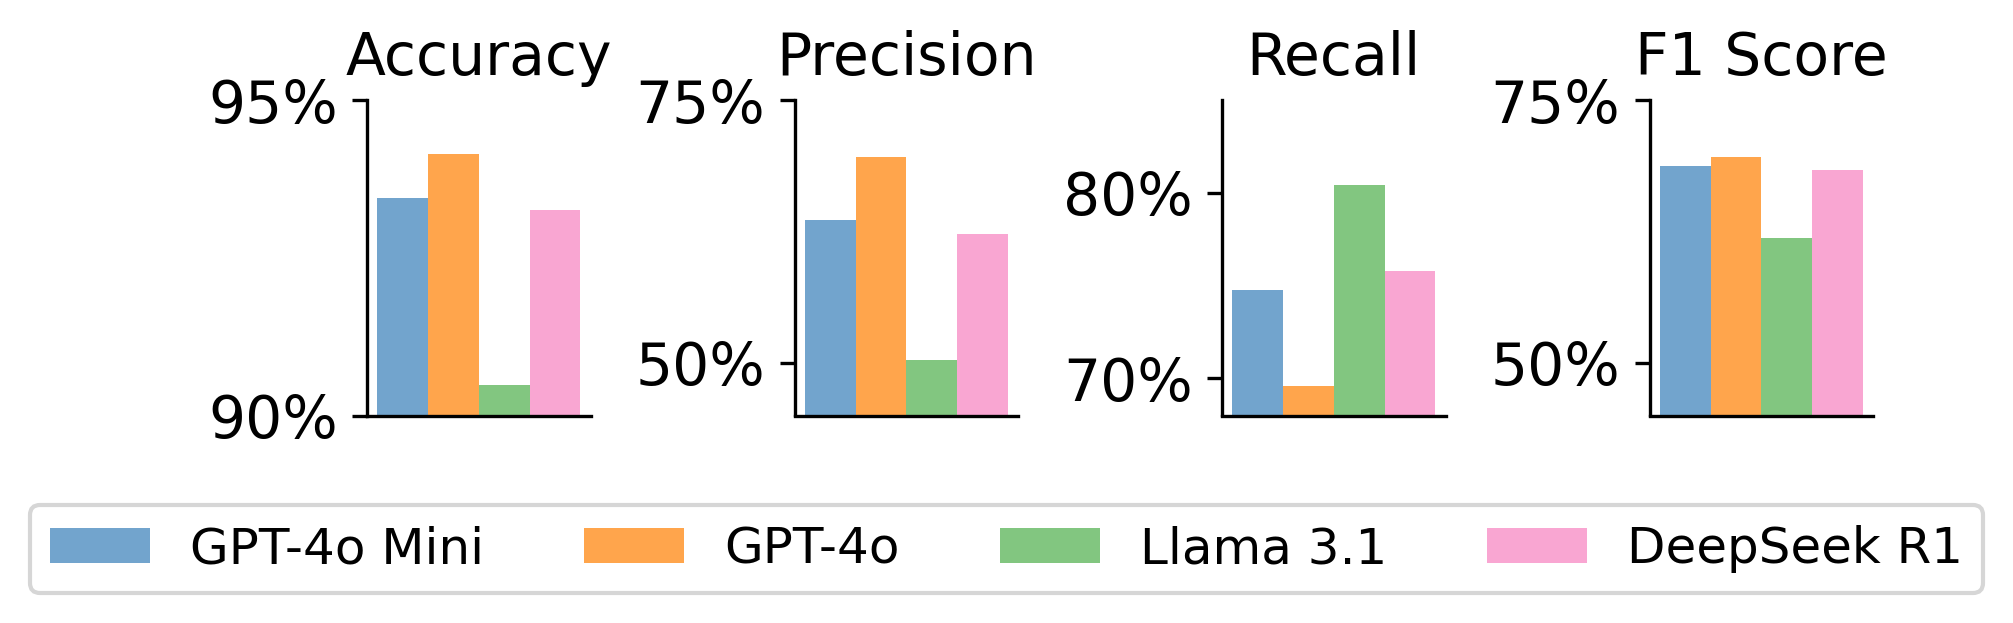

In [22]:
plot_dimensions = (1,4)
x_labels = [["" for i in range(4)]]
y_labels = [["" for i in range(4)]]
titles = [["Accuracy","Precision","Recall","F1 Score"]]
sup_y_label = ""

overall_format = {'figsize':(6, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(4)]],
    'y_lim': [[[0.9,0.95],[0.45,0.75],[0.68,0.85],[0.45,0.75]]],
    'y_ticks': [[[[0.9,0.95],["90%","95%"]],[[0.5,0.75],["50%","75%"]],[[0.7,0.8],["70%","80%"]],[[0.5,0.75],["50%","75%"]]]],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,titles=titles)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

x_groups = [0,1,2,3]
y_values = [accuracies,precisions,recalls,f1_scores]
y_errors = [[0 for i in range(len(accuracies))] for i in range(4)]
labels = nice_names

for i in range(4):
    plot_bar(ax[0][i],x_groups,y_values[i],y_errors[i],nice_names,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 4, 'bbox_to_anchor': (1.05,0.1)}
create_legend(fig,ax,plot_dimensions,legend_format)
plt.tight_layout()
fig.savefig("../../results/figures/result_comparison.pdf",dpi=300, bbox_inches='tight')

In [23]:
model_names = ["gpt-4o-mini","gpt-4o","meta-llama_Meta-Llama-3.1-8B-Instruct-Turbo","deepseek-ai_DeepSeek-R1-Distill-Qwen-14B","tf_idf","distilbert"]
nice_names = ["GPT-4o Mini","GPT-4o","Llama 3.1","DeepSeek R1","TF-IDF","BERT"]

data = [] 

for name in model_names:
    df_eval = pd.read_csv("../../results/evaluation/{}.csv".format(name))
    df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
    df_eval = df_eval.sort_values(by=['volunteer_comment'])
    df_eval = df_eval.reset_index(drop=True)
    df_eval = df_eval[eval_columns]    
    data.append(np.array(df_eval))
accuracies = [get_accuracy(pre_deploy_array,d) for d in data]
precisions = [get_precision(pre_deploy_array,d) for d in data]
recalls = [get_recall(pre_deploy_array,d) for d in data]
f1_scores = [2/(1/get_recall(pre_deploy_array,d)+1/get_precision(pre_deploy_array,d)) for d in data]
y_values = [[accuracies,precisions],[recalls,f1_scores]]

y_values = np.array(y_values)
y_values = y_values.reshape((4,6))
y_values = y_values.T
y_values = y_values.flatten().tolist()
y_values = ["{:.1f}".format(j*100)+"\\%" for j in y_values]

/tmp/ipykernel_3918617/3684091213.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_3918617/3684091213.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_3918617/3684091213.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_3918617/3684091213.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_3918617/3684091213.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_3918617/3684091213.py:8: FutureWarning: DataF

In [24]:
table = """GPT-4o Mini &     {}                         &              {}                 &    {}    &  {}        \\\\
GPT-4o      &      {}                         &              {}                 &    {}    &  {}     \\\\
Llama 3.1   &       {}                         &              {}                 &    {}    &  {} \\\\
DeepSeek R1 &      {}                         &              {}                 &    {}    &  {}     \\\\
TF-IDF      &  {}                         &              {}                 &    {}    &  {}        \\\\
DistilBERT  &  {}                         &              {}                 &    {}    &  {}    \\\\ \\bottomrule"""
print(table.format(*y_values))

GPT-4o Mini &     93.5\%                         &              63.6\%                 &    74.7\%    &  68.7\%        \\
GPT-4o      &      94.1\%                         &              69.6\%                 &    69.6\%    &  69.6\%     \\
Llama 3.1   &       90.5\%                         &              50.3\%                 &    80.4\%    &  61.9\% \\
DeepSeek R1 &      93.3\%                         &              62.3\%                 &    75.8\%    &  68.4\%     \\
TF-IDF      &  44.1\%                         &              13.8\%                 &    91.2\%    &  23.9\%        \\
DistilBERT  &  53.8\%                         &              14.0\%                 &    73.7\%    &  23.5\%    \\ \bottomrule


In [25]:
## Post-Deploy Results
post_deploy_predictions = pd.read_csv("../../data/annotations/{}.csv".format("deployment_results"))
post_deploy_predictions[eval_columns] = post_deploy_predictions[eval_columns].applymap(convert)
post_deploy_predictions = post_deploy_predictions[
    post_deploy_predictions['owner_id'].isin(set(ground_truth_post_deploy['id']))
]
post_deploy_predictions = post_deploy_predictions.sort_values(by=['volunteer_comment'])
post_deploy_predictions = post_deploy_predictions.reset_index(drop=True)
post_deploy_predictions = post_deploy_predictions[eval_columns].to_numpy() 

/tmp/ipykernel_3918617/863810502.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  post_deploy_predictions[eval_columns] = post_deploy_predictions[eval_columns].applymap(convert)


In [26]:
get_accuracy(post_deploy_array,post_deploy_predictions), get_precision(post_deploy_array,post_deploy_predictions), get_recall(post_deploy_array,post_deploy_predictions), 2/(1/get_precision(post_deploy_array,post_deploy_predictions) + 1/get_recall(post_deploy_array,post_deploy_predictions))

(0.93125, 0.6833333331055556, 0.7454545451834711, 0.7130434780128545)

In [27]:
ablations = ["gpt-4o-mini","ablation_no_guidelines","ablation_no_few_shot"]
nice_names = ["Baseline","No Guidelines","No Few Shot"]

data = [] 

for name in ablations:
    df_eval = pd.read_csv("../../results/evaluation/{}.csv".format(name))
    df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
    df_eval = df_eval.sort_values(by=['volunteer_comment'])
    df_eval = df_eval.reset_index(drop=True)
    df_eval = df_eval[eval_columns]    
    data.append(np.array(df_eval))
accuracies = [get_accuracy(pre_deploy_array,d) for d in data]
precisions = [get_precision(pre_deploy_array,d) for d in data]
recalls = [get_recall(pre_deploy_array,d) for d in data]
f1_scores = [2/(1/get_recall(pre_deploy_array,d)+1/get_precision(pre_deploy_array,d)) for d in data]

/tmp/ipykernel_3918617/2630309551.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_3918617/2630309551.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_3918617/2630309551.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)


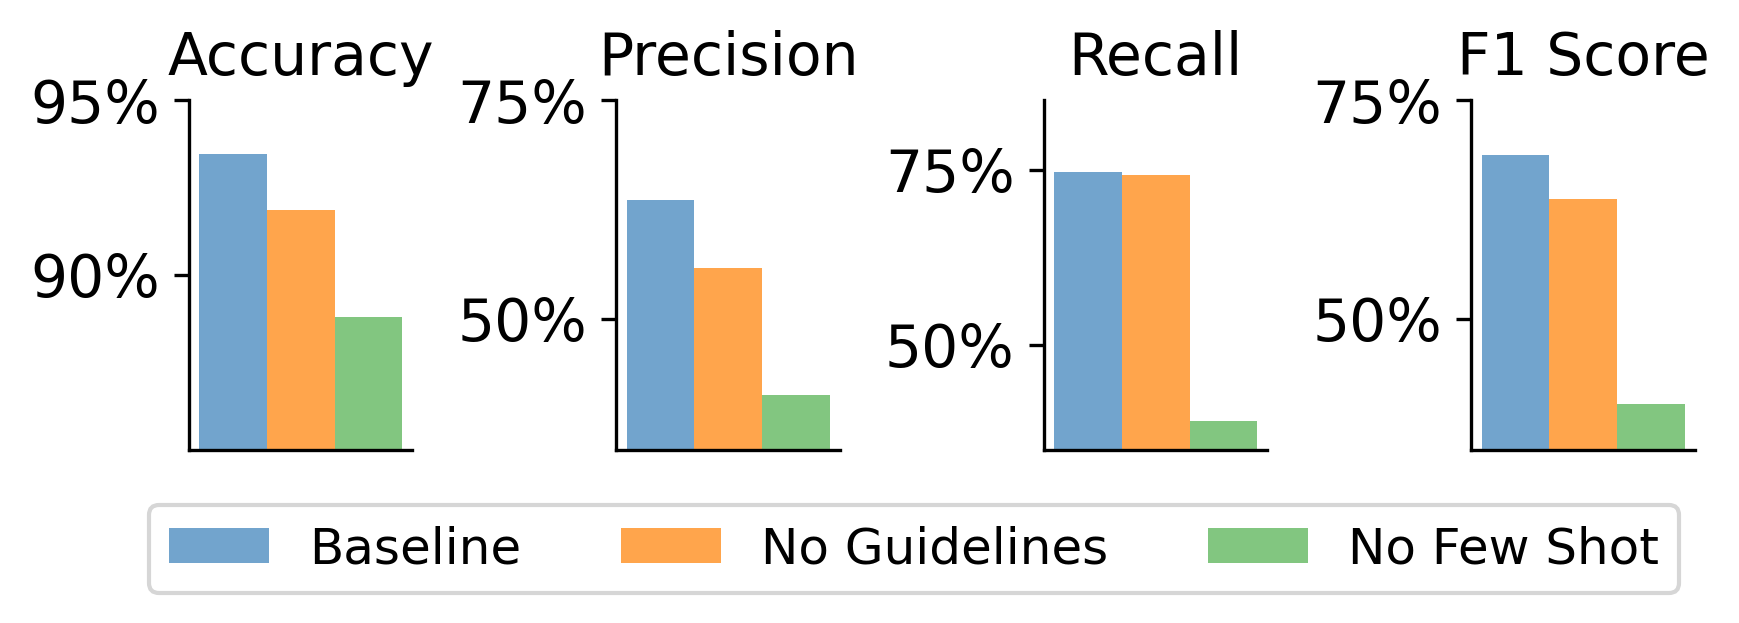

In [32]:
plot_dimensions = (1,4)
x_labels = [["" for i in range(4)]]
y_labels = [["" for i in range(4)]]
titles = [["Accuracy","Precision","Recall","F1 Score"]]
sup_y_label = ""

overall_format = {'figsize':(6, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(4)]],
    'y_lim': [[[0.85,0.95],[0.35,0.75],[0.35,0.85],[0.35,0.75]]],
    'y_ticks': [[[[0.9,0.95],["90%","95%"]],[[0.5,0.75],["50%","75%"]],[[0.5,0.75],["50%","75%"]],[[0.5,0.75],["50%","75%"]]]],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,titles=titles)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

x_groups = [0,1,2]
y_values = [accuracies,precisions,recalls,f1_scores]
y_errors = [[0 for i in range(len(accuracies))] for i in range(4)]
labels = nice_names

for i in range(4):
    plot_bar(ax[0][i],x_groups,y_values[i],y_errors[i],nice_names,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 4, 'bbox_to_anchor': (0.98,0.1)}
create_legend(fig,ax,plot_dimensions,legend_format)
plt.tight_layout()
fig.savefig("../../results/figures/ablations.pdf",dpi=300, bbox_inches='tight')

In [253]:
# Statistics for inter-rater agreement pre-deploy and post-deploy
pre_deploy_agreement = cohen_kappa_score(naveen_annotations_array.flatten(), jingwu_annotations_array.flatten())
post_deploy_agreement = cohen_kappa_score(naveen_annotations_array_post.flatten(), sean_annotations_array.flatten())
pre_deploy_agreement,post_deploy_agreement

(0.7382202499915315, 0.6098562628336757)

## Dataset Exploration

In [117]:
eval_columns = ["update_contact","inadequate_food", "earlier_pickup","system_problem","direction_problem","recipient_problem","donor_problem","positive_comment"]
nice_names = ["Update Contact","Inadequate Food","Earlier Pickup","System Problem","Direction Problem","Recipient Problem","Donor Problem","Positive Comment"]

In [118]:
all_comments_2024 = pd.read_csv(open("../../data/annotations/all_2024.csv"))
for e in eval_columns:
    all_comments_2024[e] = all_comments_2024[e].map({'f': 0, 't': 1, 'NaN': 0})
all_comments_2024.fillna(0,inplace=True)
all_comments_2024 = all_comments_2024[eval_columns].mean()
all_comments_2024 = list(all_comments_2024)

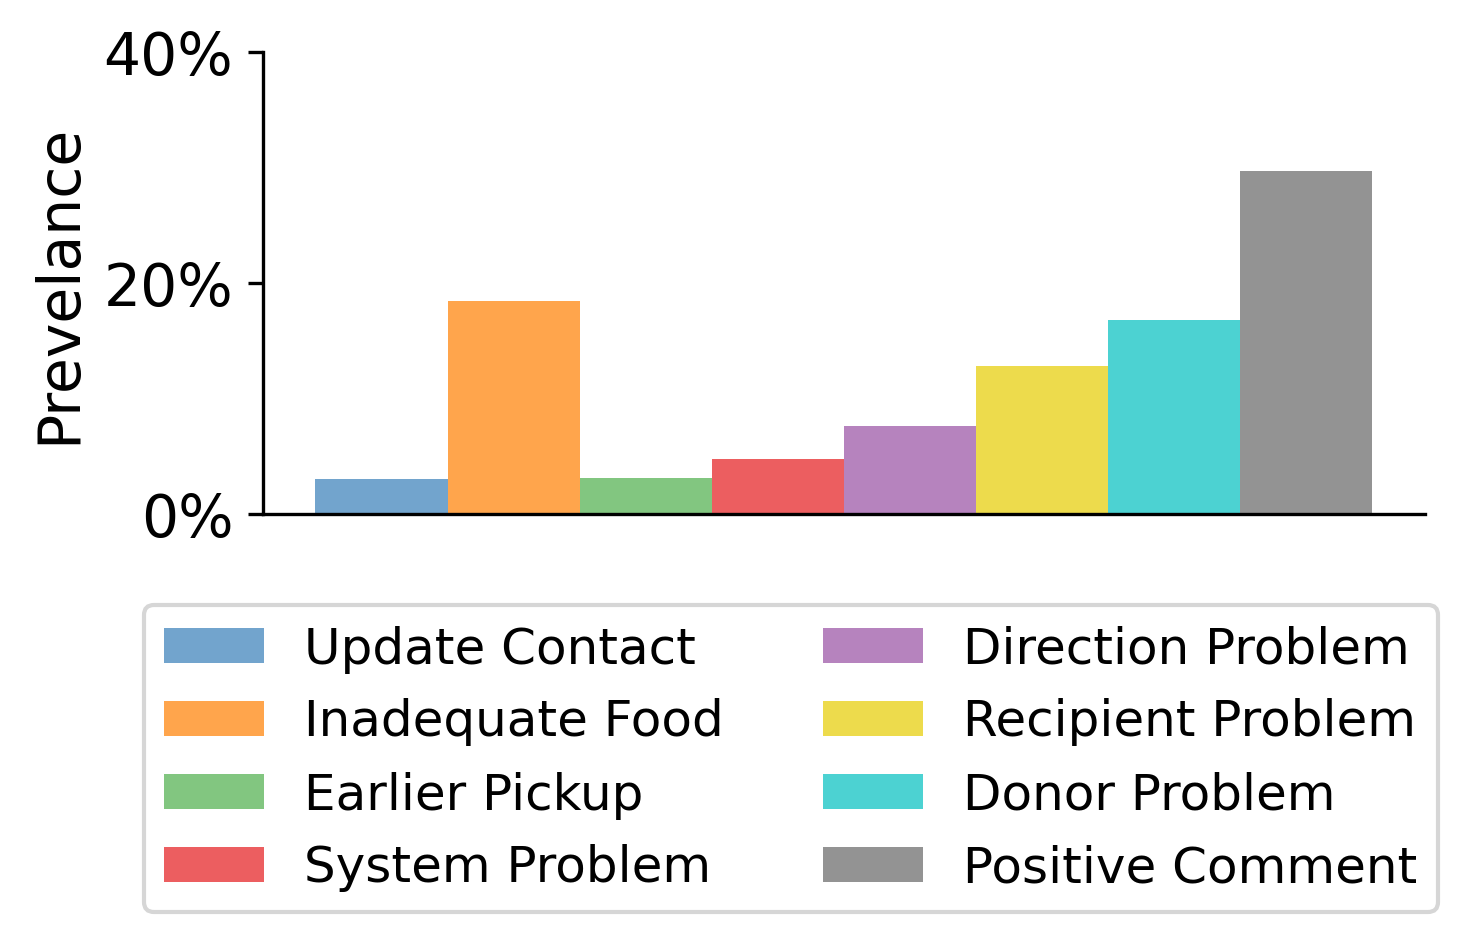

In [119]:
plot_dimensions = (1,1)
x_labels = [[""]]
y_labels = [["Prevelance"]]
sup_y_label = ""

overall_format = {'figsize':(5, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(1)] for i in range(1)],
    'y_lim': [[[0,0.4] for i in range(1)] for j in range(1)], 
    'y_ticks': [[[[0,0.2,0.4],["0%","20%","40%"]] for i in range(1)] for i in range(1)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label)

bar_format = {'style_size': style_size,
    'color_palette': 'eight_color'}

x_groups = list(range(8))
y_values = all_comments_2024
y_errors = [0 for i in range(len(x_groups))]
labels = nice_names
plot_bar(ax[0][0],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 2, 'bbox_to_anchor': (0.925,0)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/results_2024.pdf",dpi=300, bbox_inches='tight')

In [120]:
deployment_results = pd.read_csv(open("../../data/annotations/deployment_results.csv"))
deployment_results = deployment_results[eval_columns].mean()
deployment_results = list(deployment_results)

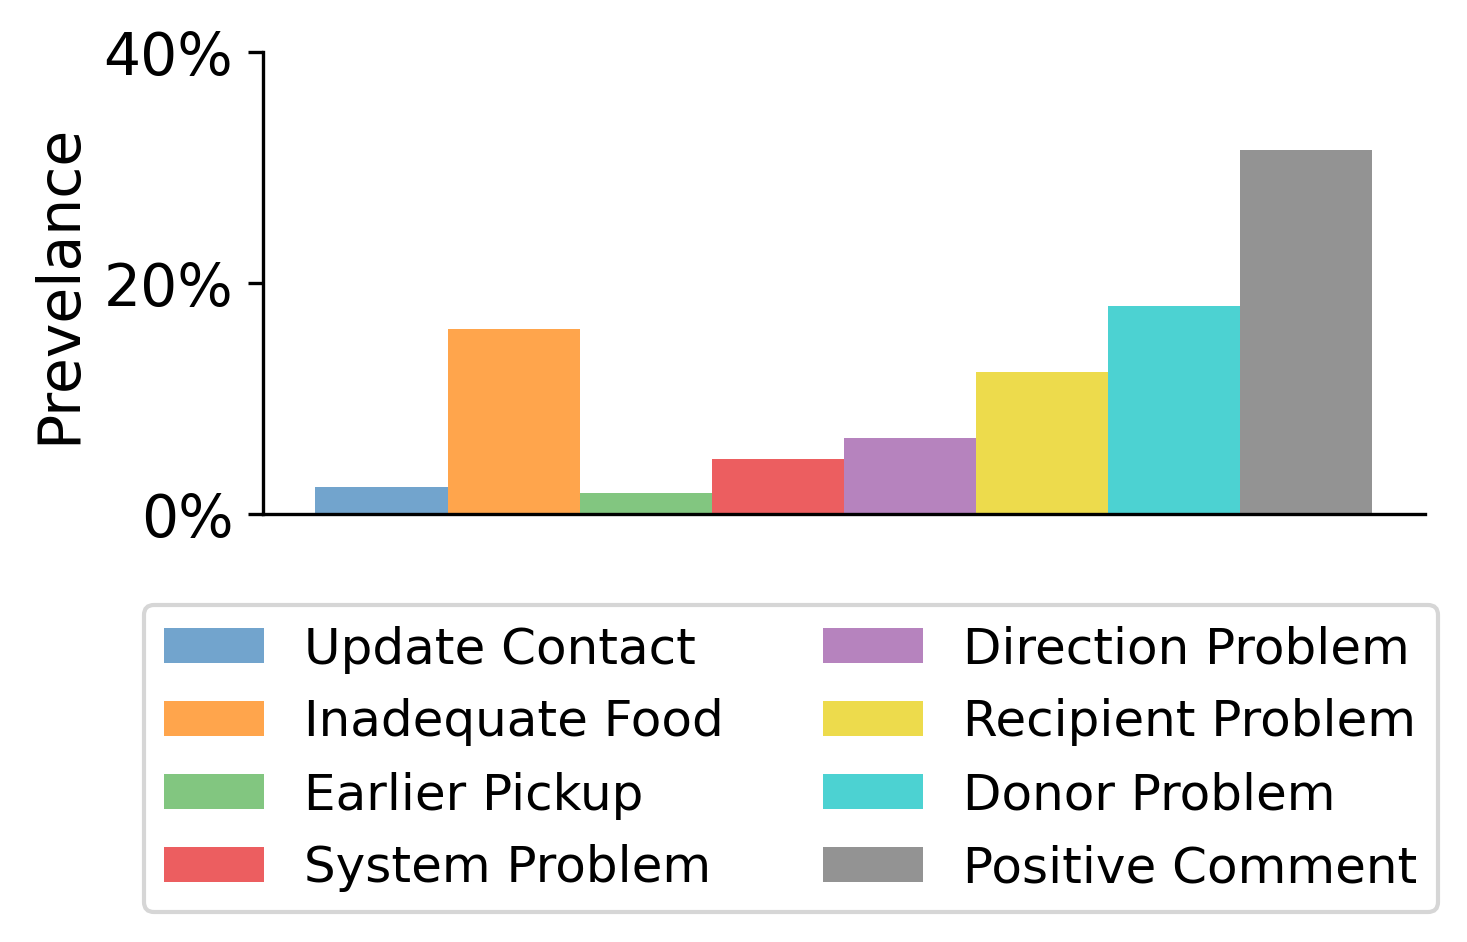

In [121]:
plot_dimensions = (1,1)
x_labels = [[""]]
y_labels = [["Prevelance"]]
sup_y_label = ""

overall_format = {'figsize':(5, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(1)] for i in range(1)],
    'y_lim': [[[0,0.4] for i in range(1)] for j in range(1)], 
    'y_ticks': [[[[0,0.2,0.4],["0%","20%","40%"]] for i in range(1)] for i in range(1)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label)

bar_format = {'style_size': style_size,
    'color_palette': 'eight_color'}

x_groups = list(range(8))
y_values = deployment_results
y_errors = [0 for i in range(len(x_groups))]
labels = nice_names
plot_bar(ax[0][0],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 2, 'bbox_to_anchor': (0.925,0)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/deploy_distribution.pdf",dpi=300, bbox_inches='tight')

In [122]:
# Trends over time on historical data
all_comments_2024 = pd.read_csv(open("../../data/annotations/all_2024.csv"))
for e in eval_columns:
    all_comments_2024[e] = all_comments_2024[e].map({'f': 0, 't': 1, 'NaN': 0})
all_comments_2024.fillna(0,inplace=True)
all_comments_2024['pickup_day'] = pd.to_datetime(all_comments_2024['pickup_day'])
all_comments_2024['days_since'] = (all_comments_2024['pickup_day'] - pd.Timestamp('2024-01-01')).dt.days
all_comments_2024

,id,owner_id,owner_type,recipient_problem,inadequate_food,donor_problem,direction_problem,earlier_pickup,system_problem,update_contact,created_at,updated_at,positive_comment,pickup_day,days_since
0,4314,812716,Rescue,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-02-12 04:47:44.424125,2025-02-12 04:47:44.424125,1.0,2024-07-09,190
1,5792,848971,Rescue,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2025-02-12 08:21:52.056433,2025-02-12 08:21:52.056433,0.0,2024-09-06,249
2,6707,9248,Route,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-02-12 11:11:41.892608,2025-02-12 11:11:41.892608,0.0,2024-10-18,291
3,4717,796197,Rescue,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2025-02-12 06:24:04.209689,2025-02-12 06:24:04.209689,0.0,2024-08-15,227
4,5029,820490,Rescue,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2025-02-12 06:24:04.209689,2025-02-12 06:24:04.209689,0.0,2024-08-14,226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8249,4783,820499,Rescue,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2025-02-12 06:24:04.209689,2025-02-12 06:24:04.209689,0.0,2024-08-12,224
8250,3872,793350,Rescue,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2025-02-12 02:54:28.852634,2025-02-12 02:54:28.852634,0.0,2024-07-02,183
8251,14167,818725,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-07-03 10:40:37.423208,2025-07-03 10:40:37.423208,1.0,2024-08-06,218
8252,4996,814172,Rescue,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2025-02-12 06:24:04.209689,2025-02-12 06:24:04.209689,0.0,2024-08-05,217


In [128]:
days_2024 = pd.date_range(start='2024-01-01', end='2024-12-31')

results = []

for day in days_2024:
    subset = all_comments_2024[all_comments_2024['pickup_day'] < day]
    subset = subset[eval_columns].sum() 
    subset = np.array(list(subset))
    if np.sum(subset) > 0:
        subset = subset/np.sum(subset)
    results.append(list(subset))
results = np.array(results).T

In [129]:
np.array(results).shape

(8, 366)

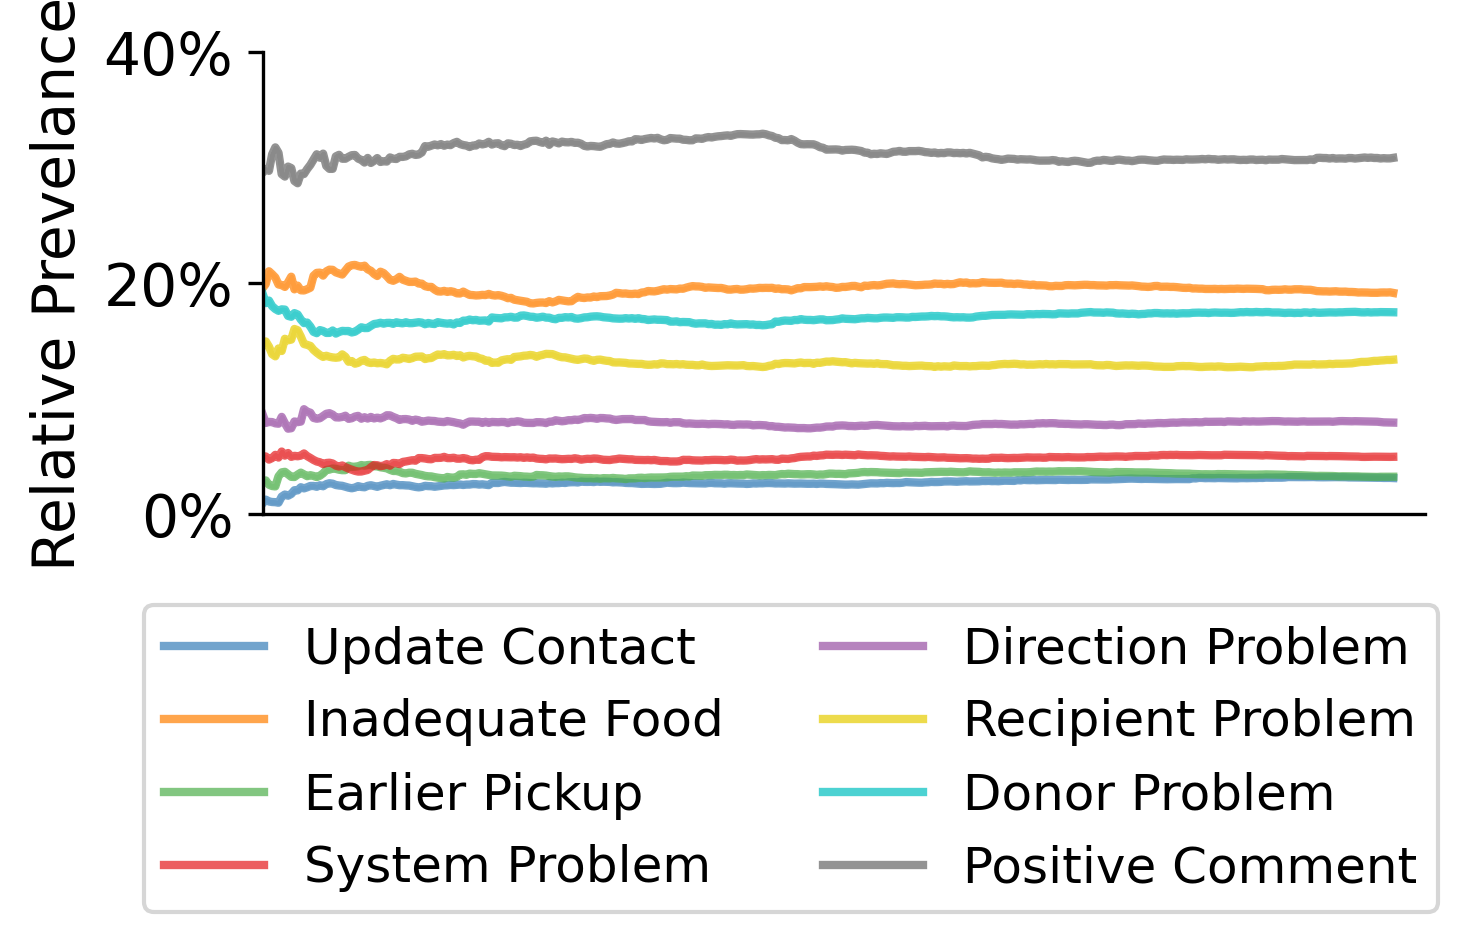

In [130]:
plot_dimensions = (1,1)
x_labels = [[""]]
y_labels = [["Relative Prevelance"]]
sup_y_label = ""

overall_format = {'figsize':(5, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(1)] for i in range(1)],
    'x_lim': [[[0,365]]],
    'y_lim': [[[0,0.4] for i in range(1)] for j in range(1)], 
    'y_ticks': [[[[0,0.2,0.4],["0%","20%","40%"]] for i in range(1)] for i in range(1)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label)

bar_format = {'style_size': style_size,
    'color_palette': 'eight_color', 'no_marker': True,     'linewidth': 2}

x_groups = list(range(len(results[0])-10))
y_values = results[:,10:]
y_errors = [0 for i in range(len(x_groups))]
labels = nice_names
plot_line(ax[0][0],[x_groups for i in range(len(y_values))],y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 2, 'bbox_to_anchor': (0.925,0)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/time_plot.pdf",dpi=300, bbox_inches='tight')

In [131]:
donor_categories = ['grocery','restaurant','non_profit','school/university','other']
donor_nice_names = ["Grocery","Restaurant","Non Profit","School","Other"]
recipient_categories = ['religous','housing','food','health','misc']
recipient_nice_names = ["Religous","Housing","Food","Health","Misc"]

donor_dict = json.load(open("../../results/other/donor_categories.json"))
recipient_dict = json.load(open("../../results/other/recipient_categories.json"))
all_comments_2024 = pd.read_csv(open("../../data/annotations/all_2024_with_donors.csv"))
for e in eval_columns:
    all_comments_2024[e] = all_comments_2024[e].map({'f': 0, 't': 1, 'NaN': 0})
all_comments_2024.fillna(0,inplace=True)


all_histograms = [[] for i in range(len(eval_columns))]
for i,category in enumerate(eval_columns):
    matching_donors = all_comments_2024[all_comments_2024[category] == 1]['donor_name']
    donor_types = [donor_dict[i] for i in matching_donors]
    donor_types = Counter(donor_types)
    as_list = []
    for d in donor_categories:
        if d not in donor_types:
            as_list.append(0)
        else:
            as_list.append(donor_types[d])
    all_histograms[i] = np.array(as_list)/np.sum(as_list)

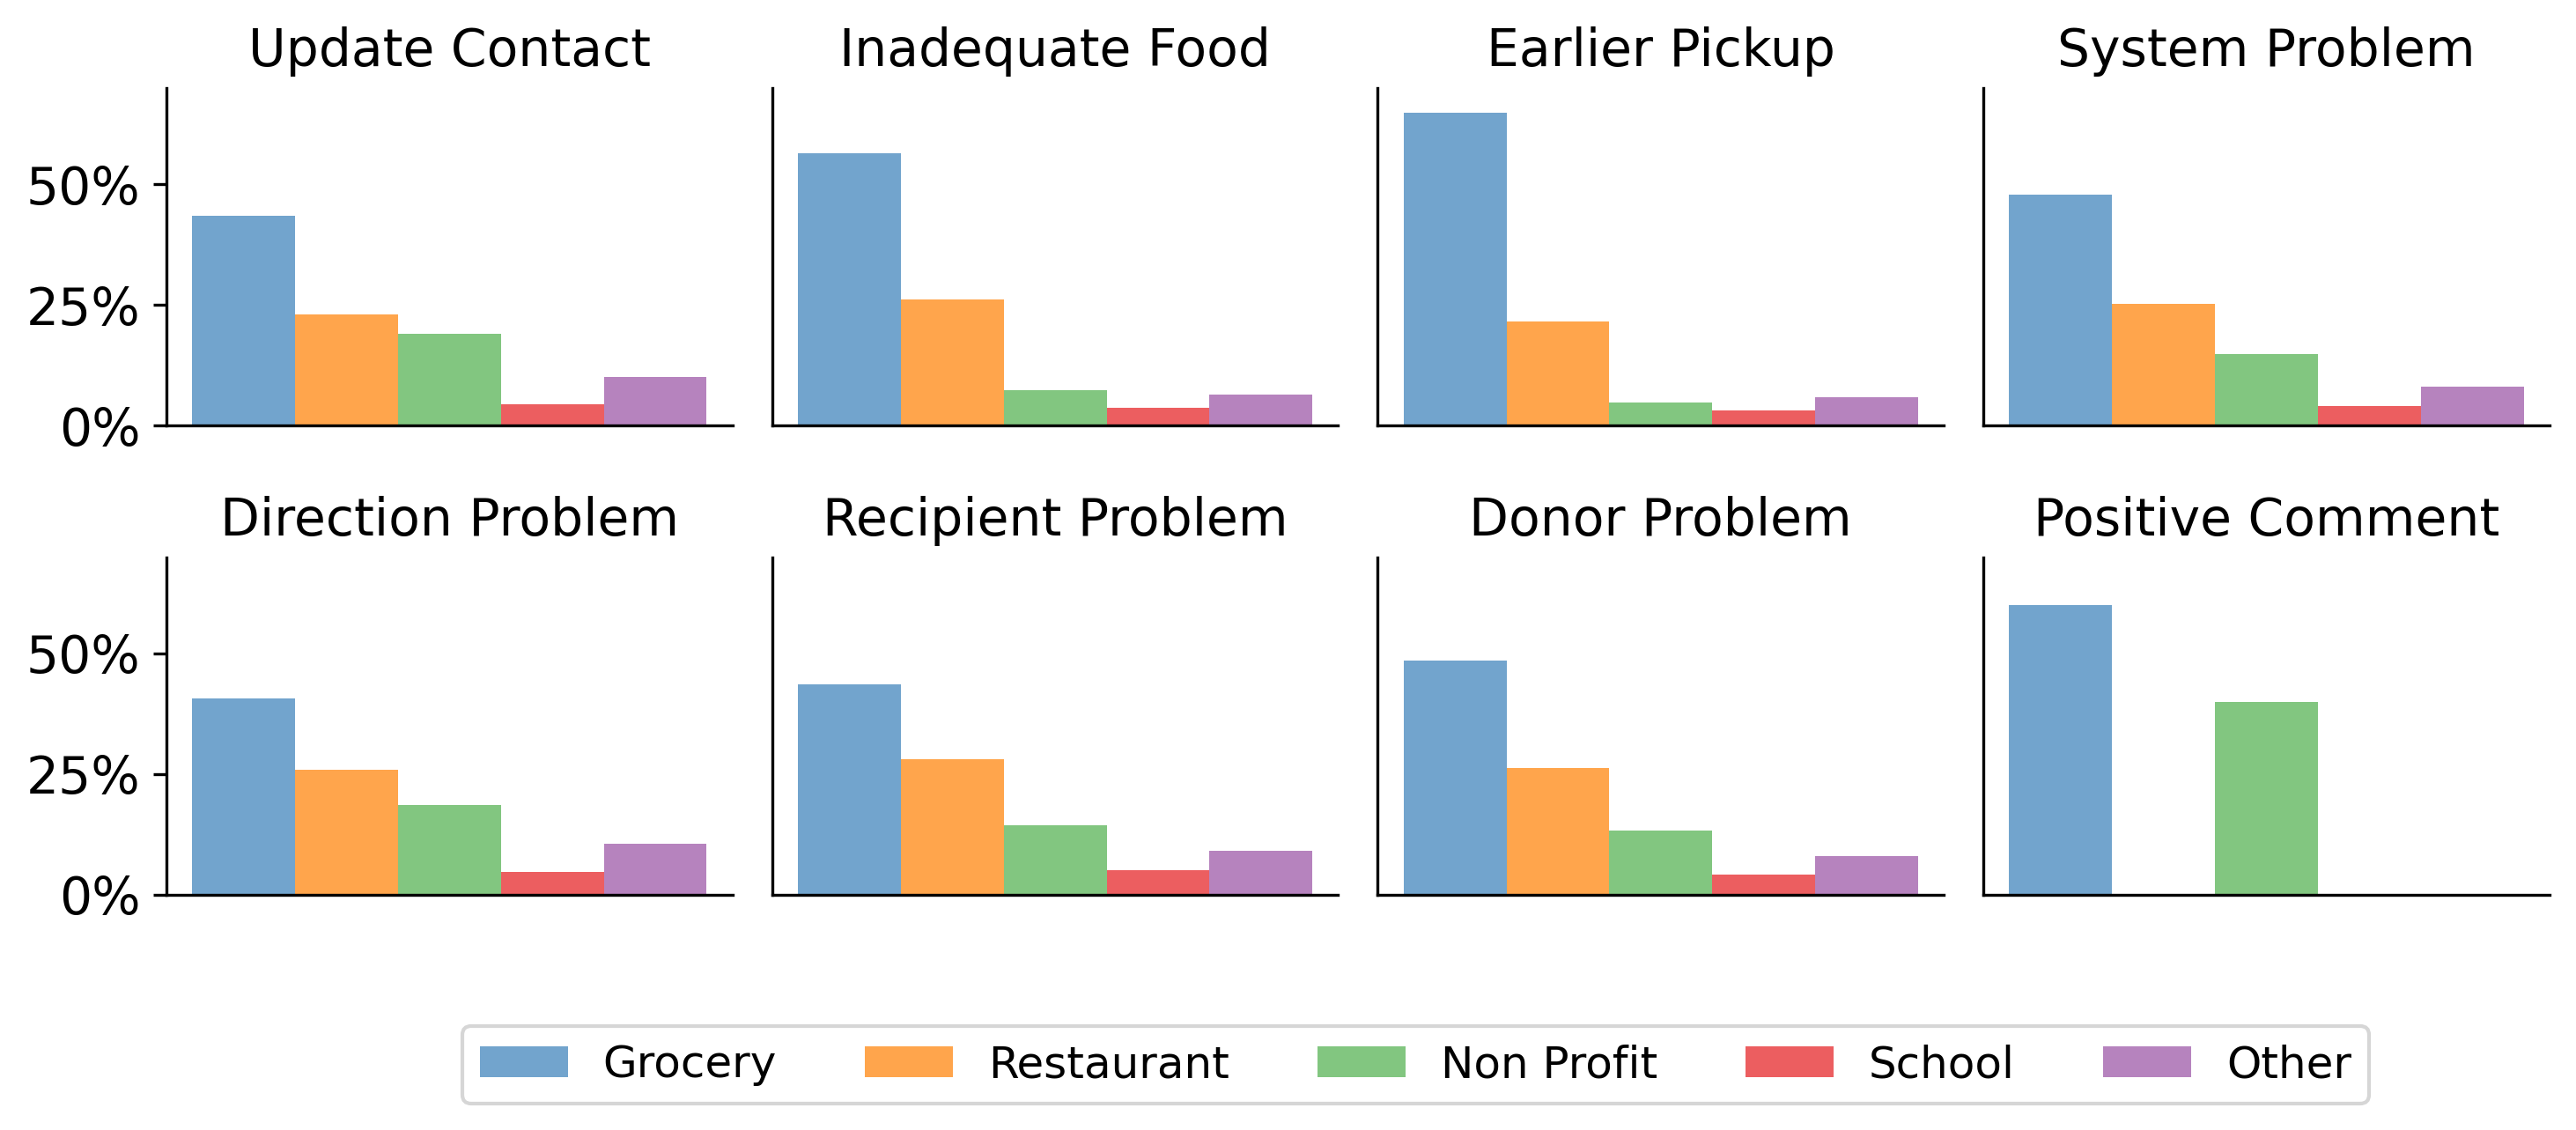

In [132]:
plot_dimensions = (2,4)
x_labels = [["" for i in range(4)] for j in range(2)]
y_labels = [["" for i in range(4)] for j in range(2)]
titles = [[nice_names[4*j+i] for i in range(4)] for j in range(2)]
sup_y_label = ""

overall_format = {'figsize':(10, 4),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(4)] for i in range(2)],
    'y_lim': [[[0,0.7] for i in range(4)] for j in range(2)], 
    'y_ticks': [[[[0,0.25,0.5],["0%","25%","50%"]] for i in range(1)]+[[[],[]] for i in range(3)] for i in range(2)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,titles=titles)

bar_format = {'style_size': style_size,
    'color_palette': 'eight_color'}

for i in range(2):
    for j in range(4):
        x_groups = list(range(len(donor_categories)))
        y_values = all_histograms[4*i+j]
        y_errors = [0 for i in range(len(x_groups))]
        labels = donor_nice_names 
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)
plt.tight_layout()
legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.925,0)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/donor_types.pdf",dpi=300, bbox_inches='tight')

In [133]:
all_histograms = [[] for i in range(len(eval_columns))]
for i,category in enumerate(eval_columns):
    matching_recipients = all_comments_2024[all_comments_2024[category] == 1]['recipient_name']
    recipient_types = [recipient_dict[i] for i in matching_recipients if i in recipient_dict]
    recipient_types = Counter(recipient_types)
    as_list = []
    for d in recipient_categories:
        if d not in recipient_types:
            as_list.append(0)
        else:
            as_list.append(recipient_types[d])
    all_histograms[i] = np.array(as_list)/np.sum(as_list)

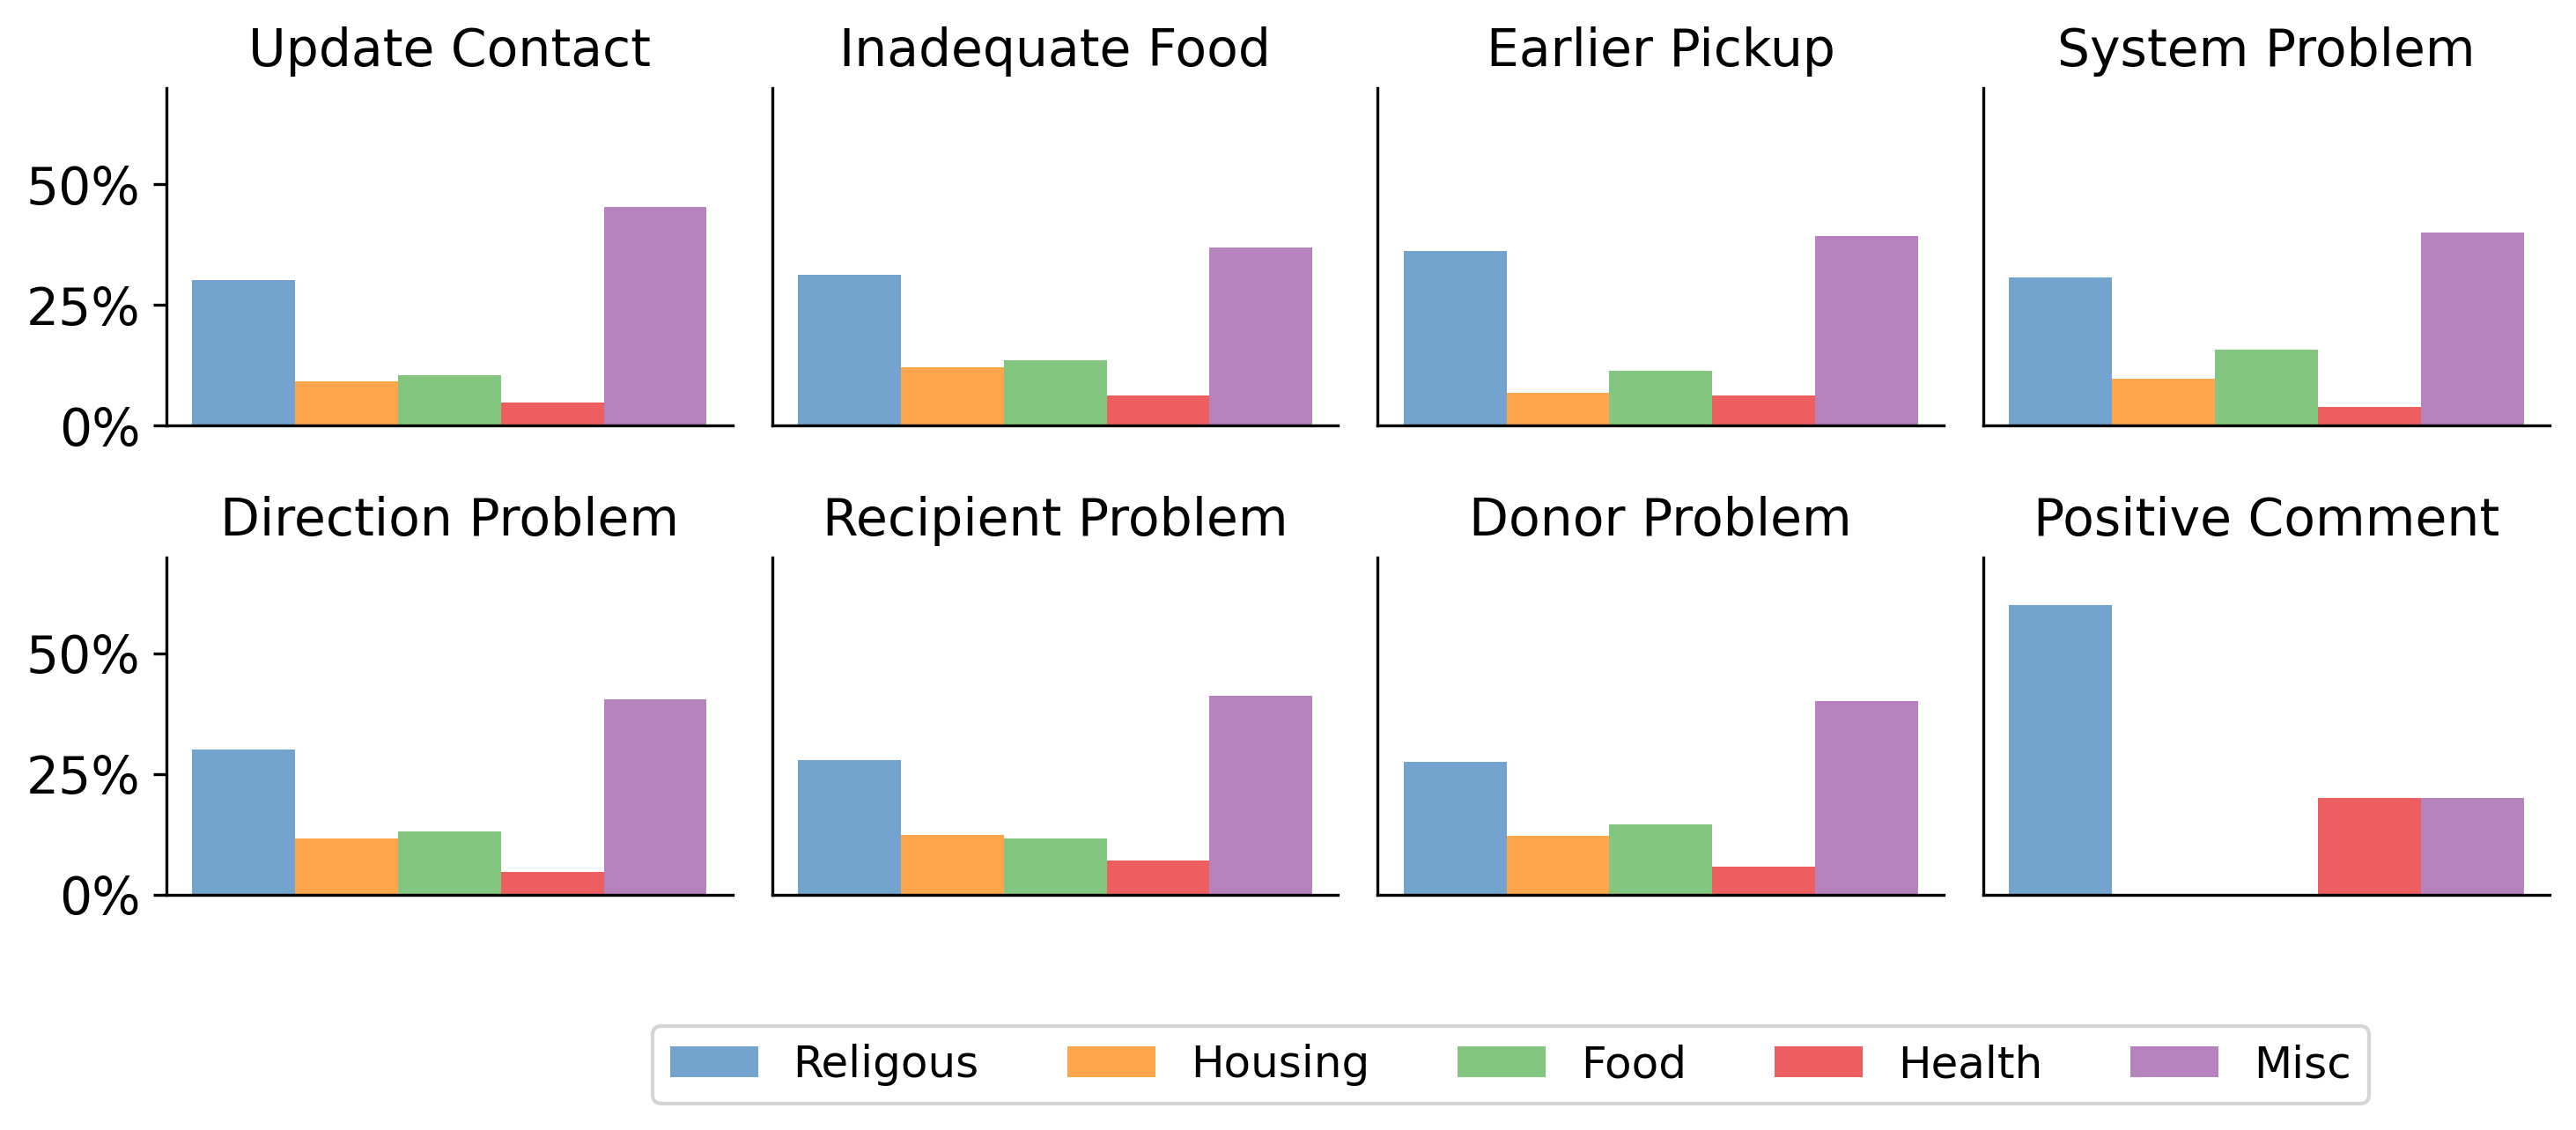

In [134]:
plot_dimensions = (2,4)
x_labels = [["" for i in range(4)] for j in range(2)]
y_labels = [["" for i in range(4)] for j in range(2)]
titles = [[nice_names[4*j+i] for i in range(4)] for j in range(2)]
sup_y_label = ""

overall_format = {'figsize':(10, 4),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(4)] for i in range(2)],
    'y_lim': [[[0,0.7] for i in range(4)] for j in range(2)], 
    'y_ticks': [[[[0,0.25,0.5],["0%","25%","50%"]] for i in range(1)]+[[[],[]] for i in range(3)] for i in range(2)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,titles=titles)

bar_format = {'style_size': style_size,
    'color_palette': 'eight_color'}

for i in range(2):
    for j in range(4):
        x_groups = list(range(len(recipient_categories)))
        y_values = all_histograms[4*i+j]
        y_errors = [0 for i in range(len(x_groups))]
        labels = recipient_nice_names 
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)
plt.tight_layout()
legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.925,0)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/recipient_types.pdf",dpi=300, bbox_inches='tight')